In [ ]:
import time
import pandas as pd
import fbprophet 
import seaborn as sns
from sklearn.cluster import KMeans

# total population by place
pop_by_place=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')

In [ ]:
pop_by_place.info()

In [ ]:
nyc=pop_by_place.iloc[[18672]]
nyc

In [ ]:
pop_by_place_ = pop_by_place.copy()[['NHGISCODE','AV0AA1970','AV0AA1980','AV0AA2000','AV0AA2010']]
pop_by_place_#.sample(5)

- ***notes***:
    - forget places with only 1 measurement 

In [ ]:
# def population_by_place(years=20):
# total population by place (1970 to 2010)
pop_by_place=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
"""
- generate DataFrame of population:
    > from 1970 to 2010
    > by unique place (use NHGISCODE as Id)
- drop 
    > counties with less than 2 measurements
        > can only predict counties which have been measured 2+ times 
- extract list of counties
    > each as a DataFrame ready for prediction 
    > column0='ds' , column1='y'
"""

# df by NHGISCODE with measurements by decade (31436 rows × 5 columns)
unique_places = pop_by_place.copy()[['NHGISCODE','AV0AA1970','AV0AA1980','AV0AA2000','AV0AA2010']]

# drop NaN rows @ thresh = 3 due to NHGISCODE being non-NaN (25103 rows × 5 columns ; 6333 non-measurable) 
measureable_unique_places = unique_places.dropna(axis=0,thresh=3)
# convert NaN values to 0 (note: there are 270 'dead' counties ('A00AA2010' == 0))
measureable_unique_places = measureable_unique_places.fillna(0)

# generate list of remaining NHGISCODE codes 
codes_of_measureable_unique_places = [code for code in measureable_unique_places.NHGISCODE]
# drop NHGISCODE column (25103 rows × 4 columns)
measureable_unique_places = measureable_unique_places.drop('NHGISCODE',axis=1)

# list of str column names as years (for conversion to datetime)
year_only_columns = [i[5:] for i in measureable_unique_places.columns]
# convert year_only_columns to DatetimeIndex of Timestamps
dt_columns = pd.to_datetime(arg=year_only_columns)

# convert dt_columns into dataframe 
datetime_df = pd.DataFrame(dt_columns).T
# w/ columns, so concatable with measureable_unique_counties
datetime_df.columns = measureable_unique_places.columns

# generate list of remaining places (each as pd.Series)
dfs_of_measureable_unique_places = [measureable_unique_places.iloc[place] for place in range(len(measureable_unique_places))]

# add datetime_df to each dataframe as first row
prophet_places = [pd.concat((datetime_df,pd.DataFrame(place).T),axis=0) for place in dfs_of_measureable_unique_places]
# then transpose to 2 rows x 23 columns 
prophet_almost_ready_places = [place.T for place in prophet_places]

In [ ]:
import pandas as pd
import fbprophet 

def population_by_place(years=20,n_places=1000,changepoint_prior=0.15,indicate=False):
    # total population by place (1970 to 2010)
    pop_by_place=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
    """
    inputs) 
    >> years
        > number of years to forecast
    >> places
        > number of places to forecast +1 
            >> e.g. 99 = first 100 places (max==25102)
    >> changepoint_prior
        > set changepoint_prior_scale for prophet model
    >> indicate
        > default False
        > if True, print number of place forecasted after each forecast
    >> time
        > default False
        > if True, prints time the function took to run right before returning output
    
    function: 
    >> generate DataFrame of population:
        > from 1970 to 2010
        > by unique place (use NHGISCODE as Id)
    >> drop 
        > places with less than 2 measurements
            > can only predict places which have been measured 2+ times 
    >> extract list of places
        > each as a DataFrame ready for prediction 
        > column0='ds' , column1='y'
    >> make and fit prophet model on each place
    >> return prophet model's predictions
        > of each place
        > for {years} years
    """

    # df by NHGISCODE with measurements by decade (31436 rows × 5 columns)
    unique_places = pop_by_place.copy()[['NHGISCODE','AV0AA1970','AV0AA1980','AV0AA2000','AV0AA2010']]

    # drop NaN rows @ thresh = 3 due to NHGISCODE being non-NaN (25103 rows × 5 columns ; 6333 non-measurable) 
    measureable_unique_places = unique_places.dropna(axis=0,thresh=3)
    # convert NaN values to 0 (note: there are 270 'dead' counties ('A00AA2010' == 0))
    measureable_unique_places = measureable_unique_places.fillna(0)

    # generate list of remaining NHGISCODE codes 
    codes_of_measureable_unique_places = [code for code in measureable_unique_places.NHGISCODE]
    # drop NHGISCODE column (25103 rows × 4 columns)
    measureable_unique_places = measureable_unique_places.drop('NHGISCODE',axis=1)

    # list of str column names as years (for conversion to datetime)
    year_only_columns = [i[5:] for i in measureable_unique_places.columns]
    # convert year_only_columns to DatetimeIndex of Timestamps
    dt_columns = pd.to_datetime(arg=year_only_columns)

    # convert dt_columns into dataframe 
    datetime_df = pd.DataFrame(dt_columns).T
    # w/ columns, so concatable with measureable_unique_counties
    datetime_df.columns = measureable_unique_places.columns

    # generate list of remaining places (each as pd.Series)
    dfs_of_measureable_unique_places = [measureable_unique_places.iloc[place] for place in range(len(measureable_unique_places))]

    # add datetime_df to each dataframe as first row
    prophet_places = [pd.concat((datetime_df,pd.DataFrame(place).T),axis=0) for place in dfs_of_measureable_unique_places]
    # then transpose to 2 rows x 23 columns 
    prophet_almost_ready_places = [place.T for place in prophet_places]

    # set collection of prophets 
    prophet_by_place = []

    # run prophet model on first 1000 places
    for place in range(len(prophet_almost_ready_places[:n_places])):
        # make the prophet model
        place_prophet = fbprophet.Prophet(changepoint_prior_scale=changepoint_prior)
        # identify county 
        a = prophet_almost_ready_places[place]
        # rename place df's columns to agree with prophet formatting
        a.columns = ['ds','y']
        # fit place on prophet model 
        b = place_prophet.fit(a)
        # make a future dataframe for 20 years
        place_forecast = place_prophet.make_future_dataframe( periods=1*years, freq='Y' )
        # establish predictions
        place_forecast = place_prophet.predict(place_forecast)
        # add to collection 
        prophet_by_place.append(place_forecast)
        # did we ask for indication (hint: do this if calculating for > 1000 places unless you enjoy anxiety)
        if indicate==True:
            # let us know the count
            print(place)
        
    # return forecasts
    return prophet_by_place

In [ ]:
by_place = population_by_place(indicate=True)

In [ ]:
len(by_place)

In [ ]:
by_place[:10]

In [ ]:
# df by NHGISCODE with measurements by decade (31436 rows × 5 columns)
unique_places = pop_by_place.copy()[['NHGISCODE','AV0AA1970','AV0AA1980','AV0AA2000','AV0AA2010']]

# drop NaN rows @ thresh = 3 due to NHGISCODE being non-NaN (25103 rows × 5 columns ; 6333 non-measurable) 
measureable_unique_places = unique_places.dropna(axis=0,thresh=3)
# convert NaN values to 0 (note: there are 270 'dead' counties ('A00AA2010' == 0))
measureable_unique_places = measureable_unique_places.fillna(0)

sample=[]
for code in measureable_unique_places[:10].NHGISCODE:
    a=pop_by_place.loc[pop_by_place['NHGISCODE'] == code]
    sample.append(a)

In [ ]:
for i in range(len(sample)):
    o=sample[i][['PLACE','STATE']]
    print(o)

In [ ]:
"""
Abbeville city  Alabama; 
2,721 2586.673761
2,699 2576.742940
2,684 2538.960959
2,654 2500.844134
2,646 2462.401057
2,627 2452.470236
2,594 2414.688255
"""
print(by_place[0][['yhat']][5:12])

In [ ]:
pop_by_place=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')

unique_places = pop_by_place.copy()[['PLACE','STATE','AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]

# drop NaN rows @ thresh = 3 due to NHGISCODE being non-NaN (25103 rows × 5 columns ; 6333 non-measurable) 
_measureable_unique_places = unique_places.dropna(axis=0,thresh=3)
# convert NaN values to 0 (note: there are 270 'dead' counties ('A00AA2010' == 0))
_measureable_unique_places = _measureable_unique_places.fillna(0)  

In [ ]:
_measureable_unique_places

In [ ]:
places_in_test

In [ ]:
pop_by_place.NHGISCODE[1]

In [ ]:
pop_by_place.copy()[['PLACE','STATE']].iloc[1]

In [ ]:
# 'Abbeville city'

In [ ]:
pop_by_place=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
all_places = [place for place in pop_by_place.PLACE]
 

def forecast_this(place,n_years=20):
    a=0
    for p in all_places:
        if p == place:
            a=pop_by_place.loc[pop_by_place['PLACE'] == place]
        elif p == place + ' city':
            a=pop_by_place.loc[pop_by_place['PLACE'] == place + ' city']
    print(a.columns)
#         # make the prophet model
#         place_prophet = fbprophet.Prophet(changepoint_prior_scale=changepoint_prior)
#         # identify county 
#         a = prophet_almost_ready_places[place]
#         # rename place df's columns to agree with prophet formatting
#         a.columns = ['ds','y']
#         # fit place on prophet model 
#         b = place_prophet.fit(a)
#         # make a future dataframe for 20 years
#         place_forecast = place_prophet.make_future_dataframe( periods=1*n_years, freq='Y' )
#         # establish predictions
#         place_forecast = place_prophet.predict(place_forecast)
#         # add to collection 
#         prophet_by_place.append(place_forecast)
forecast_this('San Francisco')

In [ ]:
for i in all_places:
    if i == 'Abbeville city':
        print('ok')

In [ ]:
actual7 = pd.read_csv('../../data/American_Community_Survey/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
actual6 = pd.read_csv('../../data/American_Community_Survey/ACS_16_5YR_S0101/ACS_16_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
actual5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
actual4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
actual3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
actual2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
actual1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 

In [ ]:
actual1

In [ ]:
a17 = actual7.copy()[['GEO.display-label','HC01_EST_VC01']][1:]
a16 = actual6.copy()[['GEO.display-label','HC01_EST_VC01']][1:]
a15 = actual5.copy()[['GEO.display-label','HC01_EST_VC01']][1:]
a14 = actual4.copy()[['GEO.display-label','HC01_EST_VC01']][1:]
a13 = actual3.copy()[['GEO.display-label','HC01_EST_VC01']][1:]
a12 = actual2.copy()[['GEO.display-label','HC01_EST_VC01']][1:]
a11 = actual1.copy()[['GEO.display-label','HC01_EST_VC01']][1:]

# len(a17),len(a16),len(a15),len(a14),len(a13),len(a12),len(a11)

In [ ]:
a17places = [place for place in a17['GEO.display-label']]
a16places = [place for place in a16['GEO.display-label']]
a15places = [place for place in a15['GEO.display-label']]
a14places = [place for place in a14['GEO.display-label']]
a13places = [place for place in a13['GEO.display-label']]
a12places = [place for place in a12['GEO.display-label']]
a11places = [place for place in a11['GEO.display-label']]

In [ ]:
combo_places=[]
for place in a17places:
    if place in a16places:
        if place in a15places:
            if place in a14places:
                if place in a13places:
                    if place in a12places:
                        if place in a11places:
                            combo_places.append(place)

In [ ]:
len(combo_places)

In [ ]:
combo_places

In [ ]:
"""
- convert dataframes to only contain shared values
"""
a17=a17.loc[a17['GEO.display-label'].isin(combo_places)]
a16=a16.loc[a16['GEO.display-label'].isin(combo_places)]
a15=a15.loc[a15['GEO.display-label'].isin(combo_places)]
a14=a14.loc[a14['GEO.display-label'].isin(combo_places)]
a13=a13.loc[a13['GEO.display-label'].isin(combo_places)]
a12=a12.loc[a12['GEO.display-label'].isin(combo_places)]
a11=a11.loc[a11['GEO.display-label'].isin(combo_places)]
# len(a17),len(a16),len(a15),len(a14),len(a13),len(a12),len(a11)
a17

In [ ]:
# load data
base=pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# select columns of measurement
get_base=base.copy()[['PLACE','STATE','AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
# drop NaN rows @ thresh = 3 due to NHGISCODE being non-NaN (25103 rows × 5 columns ; 6333 non-measurable) 
_measureable_base = get_base.dropna(axis=0,thresh=3)
# convert NaN values to 0 (note: there are 270 'dead' counties ('A00AA2010' == 0))
_measureable_base = _measureable_base.fillna(0)
_measureable_base

In [ ]:
len(_measureable_unique_places),len(_measureable_base)

In [ ]:
a15=a15.loc[a15['GEO.display-label'].isin(combo_places)]
a14=a14.loc[a14['GEO.display-label'].isin(combo_places)]
a13=a13.loc[a13['GEO.display-label'].isin(combo_places)]
a12=a12.loc[a12['GEO.display-label'].isin(combo_places)]
a11=a11.loc[a11['GEO.display-label'].isin(combo_places)]
a15

In [ ]:
a12

In [ ]:
a13

In [ ]:
a14

In [ ]:
a15

In [ ]:
# split GEO.display-label into list [place, state]
places_11_17 = [label.split(',') for label in a15['GEO.display-label']]
# make DataFrame of Place, State for compairson to _measureable_unique_places and _measureable_base
df_places_11_17 = pd.DataFrame(places_11_17,columns=['PLACE','STATE'])
# add population estimates 
eleven_seventeen = [df_places_11_17,a11.HC01_EST_VC01,a12.HC01_EST_VC01,a13.HC01_EST_VC01,a14.HC01_EST_VC01,a15.HC01_EST_VC01]
df_pop_by_place_11_17 = pd.concat(eleven_seventeen,axis=1) 

In [ ]:
df_pop_by_place_11_17

In [ ]:
_measureable_unique_places

In [ ]:
def prophet_this(place,state,prior):
    # set place state
    place_w_state=place+', '+state
    
    # 1970-2010
    sf70to10 = _measureable_unique_places.loc[_measureable_unique_places['PLACE'] == place]
    # 2011
    sf11 = a11.loc[a11['GEO.display-label'] == place_w_state]
    # 2012
    sf12 = a12.loc[a12['GEO.display-label'] == place_w_state]
    # 2013
    sf13 = a13.loc[a13['GEO.display-label'] == place_w_state]
    # 2014
    sf14 = a14.loc[a14['GEO.display-label'] == place_w_state]
    # 2015
    sf15 = a15.loc[a15['GEO.display-label'] == place_w_state]

    # combine all population measurements 
    sf_pops = sf70to10,sf11.HC01_EST_VC01,sf12.HC01_EST_VC01,sf13.HC01_EST_VC01,sf14.HC01_EST_VC01,sf15.HC01_EST_VC01

    # combine dataframes
    combo_sf = pd.concat(sf_pops,axis=1,sort=True)
    # fill lowest row NaN values with value from above rows (if exists)
    combo_sf = combo_sf.fillna(method='ffill')
    # drop rows with NaN values
    combo_sf = combo_sf.dropna(axis=0,thresh=7)

    # drop Place and State columns
    combo_sf = combo_sf.drop( ['PLACE' , 'STATE'] ,axis=1 )

    # change column names to years 1970-2010 & 2011-2015
    combo_sf.columns = ['1970', '1980', '1990', '2000', '2010', '2011','2012','2013','2014','2015']

    # list of str column names as years (for conversion to datetime)
    pre_dt_cols = [i for i in combo_sf.columns]
    # convert year_only_columns to DatetimeIndex of Timestamps
    dt_columns = pd.to_datetime(arg=pre_dt_cols)

    # convert dt_columns into dataframe 
    datetime_df = pd.DataFrame(dt_columns).T
    # w/ columns, so concatable with measureable_unique_counties
    datetime_df.columns = combo_sf.columns

    # add datetime_df as first row
    prophet_place = pd.concat((datetime_df,combo_sf),axis=0) 
    # then transpose to 2 rows x 23 columns 
    prophet_almost_ready_place = prophet_place.T

    # convert df to short 
    a = prophet_almost_ready_place

    # make the prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    
    print(a)
    if len(a.columns) == 3:
        a = a.drop(a.columns[2],axis=1)
        print(a)

    # rename place df's columns to agree with prophet formatting
    a.columns = ['ds','y']
    print(a)
    # fit place on prophet model 
    b = place_prophet.fit(a)

    # make a future dataframe for 20 years
    place_forecast = place_prophet.make_future_dataframe( periods=1*20, freq='Y' )
    # establish predictions
    sf_forecast = place_prophet.predict(place_forecast)
    
    # output predictions
    return [sf_forecast,a]

In [ ]:
# run
sf = prophet_this(place='Denver city',state='Colorado',prior=0.05)

In [ ]:
# benchmark
base_16 = int(sf[1].y[9]) + (int(sf[1].y[9])-int(sf[1].y[8]))
base_17 = base_16 + (int(sf[1].y[9])-int(sf[1].y[8]))

# predictions 2016 & 2017
p_16 = sf[0]['yhat'][11]
p_17 = sf[0]['yhat'][12]

# actual 2016 & 2017
sf16 = a16.loc[a16['GEO.display-label'] == 'Denver city, Colorado']
sf17 = a17.loc[a17['GEO.display-label'] == 'Denver city, Colorado']

In [ ]:
act_16 = int(sf16.HC01_EST_VC01)
act_17 = int(sf17.HC01_EST_VC01)
# actual - base 2016
ab16 = act_16-base_16
# pred - base 2016
ap16 = act_16-p_16
# pred - base 2017
ab17 = act_17-base_17
# pred - base 2017
ap17 = act_17-p_17

print(f"{abs(ab16)}\n{abs(int(ap16))}\n\n{abs(ab17)}\n{abs(int(ap17))}")

In [ ]:
"""
San Francisco city, California
sf = prophet_this(place='San Francisco city',state='California')
changepoint_prior_scale=0.05
-2172 27830
-66162 -24158
"""

"""
Bentonville city, Arkansas
sf = prophet_this(place='Bentonville city',state='Arkansas',prior=0.05)
335 3508
-9938 -5722
"""

"""
New York city, New York
sf = prophet_this(place='New York city',state='New York',prior=0.15)
-36636 -66472
-441471 -429353
"""

"""
New Orleans city, New Orleans
sf = prophet_this(place='New Orleans city',state='Louisiana',prior=0.15)
-2083 44438
-71863 -13624
"""
pass

In [ ]:
# san francisco forecast population through 2017
sf[0][['ds','yhat']][:13]

In [ ]:
sf16.HC01_EST_VC01.values[0],sf17.HC01_EST_VC01.values[0]

In [ ]:
sf[1]

In [ ]:
r_16 = 42499
r_17 = 34022

In [ ]:
base_16-r_16

In [ ]:
p_16-r_16

In [ ]:
base_17-r_17

In [ ]:
p_17-r_17

In [ ]:
pl_11 = a11.loc[a11['GEO.display-label'] == 'Pleasanton city, California']
pl_11

In [ ]:
out=[]
def prophet_this(place,state):
    # set place state
    place_w_state=place+', '+state
    
    # 1970-2010
    sf70to10 = _measureable_unique_places.loc[_measureable_unique_places['PLACE'] == place]
    # 2011
    sf11 = a11.loc[a11['GEO.display-label'] == place_w_state]
    # 2012
    sf12 = a12.loc[a12['GEO.display-label'] == place_w_state]
    # 2013
    sf13 = a13.loc[a13['GEO.display-label'] == place_w_state]
    # 2014
    sf14 = a14.loc[a14['GEO.display-label'] == place_w_state]
    # 2015
    sf15 = a15.loc[a15['GEO.display-label'] == place_w_state]

    # combine all population measurements 
    sf_pops = sf70to10,sf11.HC01_EST_VC01,sf12.HC01_EST_VC01,sf13.HC01_EST_VC01,sf14.HC01_EST_VC01,sf15.HC01_EST_VC01

    # combine dataframes
    combo_sf = pd.concat(sf_pops,axis=1,sort=True)
    # fill lowest row NaN values with value from above rows (if exists)
    combo_sf = combo_sf.fillna(method='ffill')
    # drop rows with NaN values
    combo_sf = combo_sf.dropna(axis=0,thresh=7)

    # drop Place and State columns
    combo_sf = combo_sf.drop(['PLACE', 'STATE'],axis=1)

    # change column names to years 1970-2010 & 2011-2015
    combo_sf.columns = ['1970', '1980', '1990', '2000', '2010', '2011','2012','2013','2014','2015']

    # list of str column names as years (for conversion to datetime)
    pre_dt_cols = [i for i in combo_sf.columns]
    # convert year_only_columns to DatetimeIndex of Timestamps
    dt_columns = pd.to_datetime(arg=pre_dt_cols)

    # convert dt_columns into dataframe 
    datetime_df = pd.DataFrame(dt_columns).T
    # w/ columns, so concatable with measureable_unique_counties
    datetime_df.columns = combo_sf.columns

    # add datetime_df as first row
    prophet_place = pd.concat((datetime_df,combo_sf),axis=0) 
    # then transpose to 2 rows x 23 columns 
    prophet_almost_ready_place = prophet_place.T

    # convert df to short 
    a = prophet_almost_ready_place

    # make the prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)

    # rename place df's columns to agree with prophet formatting
    a.columns = ['ds','y']
    # fit place on prophet model 
    b = place_prophet.fit(a)

    # make a future dataframe for 20 years
    place_forecast = place_prophet.make_future_dataframe( periods=1*20, freq='Y' )
    # establish predictions
    sf_forecast = place_prophet.predict(place_forecast)

    # benchmark 2016 & 2017
    base_16=int(prophet_almost_ready_place.y[9])+(int(prophet_almost_ready_place.y[9])-int(prophet_almost_ready_place.y[8]))
    base_17=base_16+(int(prophet_almost_ready_place.y[9])-int(prophet_almost_ready_place.y[8]))
    
    # predictions 2016 & 2017
    p_16 = sf_forecast['yhat'][11]
    p_17 = sf_forecast['yhat'][12]
    
    # actual 2016 & 2017
    sf16 = a16.loc[a16['GEO.display-label'] == place_w_state]
    sf17 = a17.loc[a17['GEO.display-label'] == place_w_state]
    
    # output base 2016 vs pred 2016 ; base 2017 vs real 2017
    return [[base_16-r_16,p_16-r_16],[base_17-r_17,p_17-r_17]]

# run
aaa=prophet_this(place='Bentonville city',state='Arkansas')
# bbb=prophet_this(place='Fayetteville city',state='Arkansas')
out.append(aaa)
# out.append(bbb)
# prophet 
out

In [77]:
import fbprophet 
import pandas as pd
from math import sqrt
import warnings
# don't do this at home
warnings.filterwarnings("ignore")


# def validate():
"""
>> takes in 
    > Census 1970-2010 dataframe (1 df)
        >> total population by Place measurements
    > American Community Survey (ACS) 2011-2017 dataframes (7 dfs)
        >> total population (age & sex) by Place 

>> forges DataFrame of places that have 
    > at least one (1) recording for Census years 1970-2010
    > at least one (1) recording for ACS years 2011-2015

>> test our model v. base on
    > random sample 100 Places
    > random sample 100 Places from bottom half population size
    > random sample 100 Places from top half population size
"""

'''load Train data'''
# population by Place Census 1970-2010 measurements
load_census_place = pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# population by Place ACS 2011
load_acs_20l1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2012
load_acs_20l2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2013
load_acs_20l3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2014
load_acs_20l4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2015
load_acs_20l5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''load Test data'''
# population by Place ACS 2016
load_acs_20l6 = pd.read_csv('../../data/American_Community_Survey/ACS_16_5YR_S0101/ACS_16_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2017
load_acs_20l7 = pd.read_csv('../../data/American_Community_Survey/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''find common places across Census and each train ACS'''
# identify Places measured in 2011 ACS [0 == 'Geography']
acs11places = [place for place in load_acs_20l1['GEO.display-label'][1:]]
# identify Places measured in 2012 ACS 
acs12places = [place for place in load_acs_20l2['GEO.display-label']]
# identify Places measured in 2013 ACS 
acs13places = [place for place in load_acs_20l3['GEO.display-label']]
# identify Places measured in 2014 ACS
acs14places = [place for place in load_acs_20l4['GEO.display-label']]
# identify Places measured in 2015 ACS 
acs15places = [place for place in load_acs_20l5['GEO.display-label']]

# cross 2011-2015, keep coexisting Places
train_places = [place for place in acs11places if place in acs12places and acs13places and acs14places and acs15places]


'''find common places across 2016 & 2017 (test ACSs)'''
# identify Places measured in 2016 ACS (29575) [0 == 'Geography']
acs16places = [place for place in load_acs_20l6['GEO.display-label'][1:]]
# identify Places measured in 2017 ACS (29577)
acs17places = [place for place in load_acs_20l7['GEO.display-label']]

# cross 2017 Places w/ 2016 Places, keep coexisting Places (29551)
base_places = [place for place in acs17places if place in acs16places]


'''find common Places across the Places our model will train on {train_places} 
    and the Places our model can predict on {base_places}'''
# identify Places we can compare our predictions with
measureable_places = [place for place in train_places if place in base_places]


'''clean Census 1970-2010 df (Train)'''
# identify columns needed to make GEO.display-label column (so can pair with ACS DataFrames) 
for_geo_displays = ['PLACE','STATE']
# pull those columns 
to_geo_displays = load_census_place[for_geo_displays]

# mold PLACE column into list with Place formatted as is in GEO.display-label
places_70_10 = [place + ', ' for place in to_geo_displays.PLACE]

# list paired State for each Place
states_70_10 = [state for state in to_geo_displays.STATE]

# merge places_70_10 and states_70_10 into list formatted as GEO.display-label column
GEO_display_label = [ places_70_10[i] + states_70_10[i] for i in range(len(places_70_10))]

# identify columns relevant to our end goal of predicting population for a given place
place_cols_of_interest = ['AV0AA1970', 'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010']
# set base dataframe using Census (1970-2010) measurements 
pop_place_70_10_ = load_census_place[place_cols_of_interest]

# add GEO.display-label column from GEO_display_label list
pop_place_70_10_['GEO.display-label'] = GEO_display_label


'''clean American Community Survey (ACS) 2011-2015 dataframes (Train)'''
# ID columns we will be using
columns = ['GEO.display-label', 'HC01_EST_VC01']
# convert 2011
acs_20l1 = load_acs_20l1[columns]
# convert 2012
acs_20l2 = load_acs_20l2[columns]
# convert 2013
acs_20l3 = load_acs_20l3[columns]
# convert 2014
acs_20l4 = load_acs_20l4[columns]
# convert 2015
acs_20l5 = load_acs_20l5[columns]


'''convert Train years to reflect Places only seen in measureable_places'''
# drop Census Places not ideal for measurement (29346)
census_place_populations = pop_place_70_10_.loc[pop_place_70_10_['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2011_place_populations = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2012_place_populations = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2013_place_populations = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2014_place_populations = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341) 
acs_2015_place_populations = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(measureable_places)]


'''clean ACS 2016 & 2017 dataframes (Test)
    take a sample of 100 Places to score our model'''
# identify 2016/2017 columns of interest (to measure against)
test_col_of_i = ['GEO.display-label', 'HC01_EST_VC01']

# shrink ACS 2017 df to columns to measure against only 
testd_16_ = load_acs_20l6[test_col_of_i]
# realize ACS 2016 combined measureable_places DataFrame (Baseline) dataframe 
test_16_df_ = testd_16_.loc[testd_16_['GEO.display-label'].isin(measureable_places)]

# shrink ACS 2017 df to columns to measure against only 
testd_17_ = load_acs_20l7[test_col_of_i]
# realize ACS 2017 combined measureable_places DataFrame (Baseline) dataframe 
test_17_df_ = testd_17_.loc[testd_17_['GEO.display-label'].isin(measureable_places)]
# drop Places with 0 value in 2017 (will be sampling from 2017, values of 0 in 2016 are also 0 in 2017 or do not exits)
test_17_df_ = test_17_df_.loc[test_17_df_.HC01_EST_VC01 != '0']

# sample Baseline data for Places to evaluate model 
sample_one_hunnit = test_17_df_.sample(100)
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]


'''adjust Train dataframes to sampled Places'''
# shrink Census DataFrame to sampled Places
_s_census_ = census_place_populations.loc[census_place_populations['GEO.display-label'].isin(sample_places)]
# shrink 2011 ACS df to sampled Places 
_s_acs_2011_ = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(sample_places)]
# shrink 2012 ACS DataFrame to sampled Places 
_s_acs_2012_ = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(sample_places)]
# shrink 2013 ACS df to Places in sample  
_s_acs_2013_ = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(sample_places)]
# shrink 2014 ACS DataFrame to sampled Places 
_s_acs_2014_ = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(sample_places)]
# shrink 2015 ACS df to sampled Places 
_s_acs_2015_ = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(sample_places)]


'''adjust Test dataframes to sampled Places'''
# 2016 ACS df to sampled Places 
test_16_df = test_16_df_.loc[test_16_df_['GEO.display-label'].isin(sample_places)]
# 2017 ACS DataFrame to sampled Places 
test_17_df = test_17_df_.loc[test_17_df_['GEO.display-label'].isin(sample_places)]


'''forge Train DataFrame'''
# set Census index to Places, and forget Place column 
s_census_ = _s_census_.copy().set_index(_s_census_['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
# rename Census columns to years for later datetime conversion
s_census_.columns = ['1970','1980','1990','2000','2010']

# set 2011 index to Places 
s_acs_2011_ = _s_acs_2011_.copy().set_index(_s_acs_2011_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2011_.columns = ['no','2011']
s_acs_2011_ = s_acs_2011_['2011']

# set 2012 index to Places 
s_acs_2012_ = _s_acs_2012_.copy().set_index(_s_acs_2012_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2012_.columns = ['no','2012']
s_acs_2012_ = s_acs_2012_['2012']

# set 2013 index to Places 
s_acs_2013_ = _s_acs_2013_.copy().set_index(_s_acs_2013_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2013_.columns = ['no','2013']
s_acs_2013_ = s_acs_2013_['2013']

# set 2014 index to Places 
s_acs_2014_ = _s_acs_2014_.copy().set_index(_s_acs_2014_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2014_.columns = ['no','2014']
s_acs_2014_ = s_acs_2014_['2014']

# set 2015 index to Places 
s_acs_2015_ = _s_acs_2015_.copy().set_index(_s_acs_2015_['GEO.display-label'])
# rename Census columns to years for later datetime conversion & forget Place column 
s_acs_2015_.columns = ['no','2015']
s_acs_2015_ = s_acs_2015_['2015']

# forge Train DataFrame and convert NaN values to 0 (assumes population not measured is 0) 
train_df = pd.concat([s_census_,s_acs_2011_,s_acs_2012_,s_acs_2013_,s_acs_2014_,s_acs_2015_],axis=1).fillna(0)


'''forecast 2016 and 2017 populations using model for each sample Place'''
# set out route for forecast tables
out = []
# set out route for 2016 & 2017 Train predictions
train_preds = []
# make DataFrame of column values as datetime
datetimes = pd.DataFrame(data=pd.to_datetime(pd.Series(data=train_df.columns)))
# go though each place in train_df
for i in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[i]
    # add datetime values to DataFrame
    df = pd.concat([df.reset_index(),datetimes],axis=1)
    # use fbprophet to make Prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    # rename Place df's columns to agree with prophet formatting
    df.columns = ['drop','y','ds']
    # adjust df ; forget index column (drop)
    df = df[['ds','y']]
    # fit place on prophet model 
    place_prophet.fit(df)
    # make a future dataframe for 2016 & 2017 years
    place_forecast = place_prophet.make_future_dataframe( periods=3, freq='Y' )
    # establish predictions
    forecast = place_prophet.predict(place_forecast)
    # tag and bag (forecast table)
    out.append(forecast)
    # store 2016 and 2017 predictions
    train_preds.append([forecast[-2:].yhat.values[0],forecast[-2:].yhat.values[1]])


'''make Baseline predictions of 2016 and 2017 population on sample Places'''
# set out route
baseline_preds = []
# go though each place in train_df
for j in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[j]
    # identify 2014 population
    prior = int(df['2014'])
    # identify 2015 population
    past = int(df['2015'])
    # calculate change
    change = past - prior
    # make 2016 prediction 
    p_16 = past + change
    # make 2017 prediction 
    p_17 = p_16 + change
    # pair prediction, tag & bag
    baseline_preds.append([p_16,p_17])


'''pull actual measurements for 2016 and 2017 population for each sample Place'''
# actual populations for 2016
test_16 = [actual_population for actual_population in test_16_df.HC01_EST_VC01]
# actual populations for 2017
test_17 = [actual_population for actual_population in test_17_df.HC01_EST_VC01]


'''compare Train vs Test to Baseline vs Test
    measure how close (%) Train is to Baseline in compairson to Test'''
# track closeness of Train prediction to actual
measure_2016_train = 0
# track closeness of Baseline prediction to actual
measure_2016_base = 0

# start measuring 2016
for i in range(len(test_16)):
    # add Train error
    measure_2016_train += float(test_16[i]) / float(train_preds[i][0])
    # add Baseline error
    measure_2016_base += float(test_16[i]) / float(baseline_preds[i][0])

# track closeness of Train prediction to actual
measure_2017_train = 0
# track closeness of Baseline prediction to actual
measure_2017_base = 0

# start measuring 2016
for i in range(len(test_16)):
    # add Train error
    measure_2017_train += float(test_17[i]) / float(train_preds[i][1])
    # add Baseline error
    measure_2017_base += float(test_17[i]) / float(baseline_preds[i][1])

measure_2016_train,measure_2016_base,measure_2017_train,measure_2017_base

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet wi

INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seaso

(92.750875971072, 131.15049766580546, 90.77739031581378, 103.12381066610342)

In [125]:
out[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01,141.802500,770.132711,2285.097679,141.802500,141.802500,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,0.0,0.0,0.0,1504.781478
1,1980-01-01,715.512502,1394.508988,2982.248813,715.512502,715.512502,1485.407838,1485.407838,1485.407838,1485.407838,1485.407838,1485.407838,0.0,0.0,0.0,2200.920340
2,1990-01-01,1289.379602,1836.251467,3447.304079,1289.379602,1289.379602,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,0.0,0.0,0.0,2652.358580
3,2000-01-01,1863.089597,2619.589775,4119.042987,1863.089597,1863.089597,1485.407838,1485.407838,1485.407838,1485.407838,1485.407838,1485.407838,0.0,0.0,0.0,3348.497435
4,2010-01-01,2436.956663,3045.917994,4616.295380,2436.956663,2436.956663,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,0.0,0.0,0.0,3799.935640
5,2011-01-01,2494.296241,3155.094600,4690.167173,2494.296241,2494.296241,1424.701157,1424.701157,1424.701157,1424.701157,1424.701157,1424.701157,0.0,0.0,0.0,3918.997398
6,2012-01-01,2551.635820,3218.017652,4784.043538,2551.635820,2551.635820,1485.407838,1485.407838,1485.407838,1485.407838,1485.407838,1485.407838,0.0,0.0,0.0,4037.043658
7,2013-01-01,2609.132493,3153.859992,4663.107874,2609.132493,2609.132493,1300.316399,1300.316399,1300.316399,1300.316399,1300.316399,1300.316399,0.0,0.0,0.0,3909.448893
8,2014-01-01,2666.472072,3264.437710,4800.628017,2666.472072,2666.472072,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,1362.978977,0.0,0.0,0.0,4029.451050
9,2015-01-01,2723.811651,3318.510111,4928.097865,2723.811651,2723.811651,1424.701157,1424.701157,1424.701157,1424.701157,1424.701157,1424.701157,0.0,0.0,0.0,4148.512808


In [95]:
# aggregate error
m = [measure_2016_train,measure_2016_base,measure_2017_train,measure_2017_base]
# square root error
mse = [sqrt(abs(i)) for i in m]
# display
m,mse

([92.750875971072, 131.15049766580546, 90.77739031581378, 103.12381066610342],
 [9.630725620173799, 11.452095776136588, 9.527716951915279, 10.15498944687307])

In [102]:
# compare model to base 2016
comp_model_base_16 = 100*(1-mse[0]/mse[1])
# compare model to base 2017
comp_model_base_17 = 100*(1-mse[2]/mse[3])
comp_model_base_16,comp_model_base_17,(comp_model_base_16+comp_model_base_17)/2

(15.90425186417046, 6.176988151877816, 11.040620008024138)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


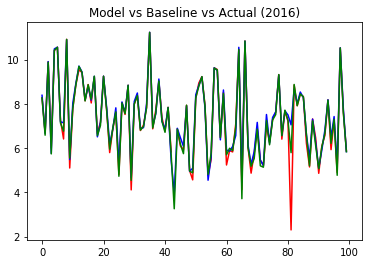

In [120]:
# baseline 2016
baseline_preds_2016 = [np.log(pred[0]) for pred in baseline_preds]
# train 2016
train_preds_2016 = [np.log(pred[0]) for pred in train_preds]
# actual 2016
test_16_actual = [np.log(int(actual)) for actual in test_16] 

plt.plot(baseline_preds_2016,'r-',label='Model');
plt.plot(train_preds_2016,'b-',label='Baseline');
plt.plot(test_16_actual,'g-',label='Actual');
# title graph
plt.title(label='Model vs Baseline vs Actual (2016)')
# display graph
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


ValueError: x and y must be the same size

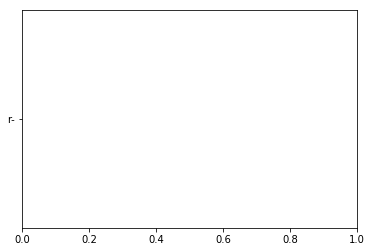

In [127]:
# baseline 2016
baseline_preds_2016 = [np.log(pred[0]) for pred in baseline_preds]
# train 2016
train_preds_2016 = [np.log(pred[0]) for pred in train_preds]
# actual 2016
test_16_actual = [np.log(int(actual)) for actual in test_16] 

plt.scatter(baseline_preds_2016,'r-',label='Model');
plt.scatter(train_preds_2016,'b-',label='Baseline');
plt.scatter(test_16_actual,'g-',label='Actual');
# title graph
plt.title(label='Model vs Baseline vs Actual (2016)')
# display graph
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


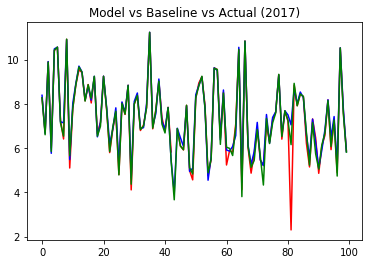

In [124]:
# baseline 2017
baseline_preds_2017 = [np.log(pred[0]) for pred in baseline_preds]
# train 2017
train_preds_2017 = [np.log(pred[0]) for pred in train_preds]
# actual 2017
test_17_actual = [np.log(int(actual)) for actual in test_17] 

plt.plot(baseline_preds_2017,'r-',label='Model');
plt.plot(train_preds_2017,'b-',label='Baseline');
plt.plot(test_17_actual,'g-',label='Actual');
# title graph
plt.title(label='Model vs Baseline vs Actual (2017)')
# ax.set_xlabel("x label")
# display graph
plt.show()

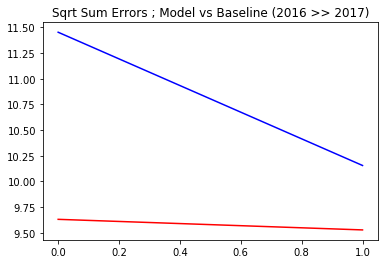

In [104]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
# ax.plot(mse[:2]);
# ax.plot(mse[:2]);
# predictions error
plt.plot([mse[0],mse[2]],'r-',label='Model');
# baseline error
plt.plot([mse[1],mse[3]],'b-',label='Baseline');
# title graph
plt.title(label='Sqrt Sum Errors ; Model vs Baseline (2016 >> 2017)')
# display graph
plt.show()


In [21]:
out[0][-2:].yhat.values[0]

2680.804345697886

In [7]:
test_16_df.HC01_EST_VC01

,GEO.display-label,HC01_EST_VC01
1,"Abanda CDP, Alabama",151
2,"Abbeville city, Alabama",2627
3,"Adamsville city, Alabama",4422
4,"Addison town, Alabama",757
5,"Akron town, Alabama",252
6,"Alabaster city, Alabama",32269
7,"Albertville city, Alabama",21434
8,"Alexander City city, Alabama",14859
9,"Alexandria CDP, Alabama",3980
10,"Aliceville city, Alabama",3218


In [30]:
100/92

1.0869565217391304

In [ ]:
baseline_preds

In [ ]:
# census
qtqt=s_census_.head().copy()
qtqt=qtqt.set_index(qtqt['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
qtqt.columns=['1970','1980','1990','2000','2010']
# 2011
t_q_=s_acs_2011_.head().copy()
t_q_=t_q_.set_index(t_q_['GEO.display-label'])
t_q_.columns=['no','2011']
t_q_=t_q_['2011']
# 2015
tqtq=s_acs_2015_.head().copy()
tqtq=tqtq.set_index(tqtq['GEO.display-label'])
tqtq.columns=['no','2015']
tqtq=tqtq['2015']
pd.concat([qtqt,t_q_,tqtq],axis=1)

In [ ]:
tqtq=s_acs_2015_.head().copy()
tqtq=tqtq.set_index(tqtq['GEO.display-label'])#['HC01_EST_VC01']
tqtq.columns=['no','2015']
tqtq=tqtq['2015']
tqtq

In [ ]:
t_q_=s_acs_2011_.head().copy()
t_q_=t_q_.set_index(t_q_['GEO.display-label'])#['HC01_EST_VC01']
t_q_.columns=['no','2011']
t_q_=t_q_['2011']
t_q_

In [ ]:
qtqt=s_census_.head().copy()
qtqt=qtqt.set_index(qtqt['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
qtqt

In [ ]:
# qtqt=qtqt.join(t_q_, how='outer')
# qtqt=qtqt.join(tqtq, how='outer')
pd.concat([qtqt,t_q_,tqtq])

In [ ]:
load_acs_20l7

In [ ]:
measureable_places.sample(100)

In [ ]:
# for i,j in enumerate(census_place_populations['GEO.display-label']):
#     if j not in acs_2011_place_populations['GEO.display-label']:
#         print(i,j)
len(census_place_populations['GEO.display-label']), len(acs_2011_place_populations['GEO.display-label'])

In [ ]:
q=[]
for i,j in enumerate(acs_2012_place_populations['GEO.display-label']):
    if j not in q:
        q.append(j)
    else:
        print(i,j)

In [ ]:
o=[]
for i,j in enumerate(census_place_populations['GEO.display-label']):
    if j not in o:
        o.append(j)
    else:
        print(i,j)

In [ ]:
o[:116]

In [ ]:
len(census_place_populations['GEO.display-label']),len(list(census_place_populations['GEO.display-label'])),len(set(census_place_populations['GEO.display-label']))

In [ ]:
census_place_populations#['GEO.display-label']

In [ ]:
len(train_places),len(base_places),len(measureable_places)

In [ ]:
'''convert train years to reflect Places only seen in base_places'''
# drop Census Places not found in ACS 2016 and ACS 2017 
census_place_populations = pop_place_70_10_.loc[pop_place_70_10_['GEO.display-label'].isin(combo_places)]
# drop 2011 ACS Places not found in ACS 2016 and ACS 2017 
acs_2011_place_populations = load_acs_20l1.loc[load_acs_20l1['GEO.display-label'].isin(combo_places)]
# drop 2011 ACS Places not found in ACS 2016 and ACS 2017 
acs_2012_place_populations = load_acs_20l2.loc[load_acs_20l1['GEO.display-label'].isin(combo_places)]
# drop 2011 ACS Places not found in ACS 2016 and ACS 2017 
acs_2013_place_populations = load_acs_20l3.loc[load_acs_20l1['GEO.display-label'].isin(combo_places)]
# drop 2011 ACS Places not found in ACS 2016 and ACS 2017 
acs_2014_place_populations = load_acs_20l4.loc[load_acs_20l1['GEO.display-label'].isin(combo_places)]
# drop 2011 ACS Places not found in ACS 2016 and ACS 2017 
acs_2015_place_populations = load_acs_20l5.loc[load_acs_20l1['GEO.display-label'].isin(combo_places)]

'''build Train dataframe'''


# a15=a15.loc[a15['GEO.display-label'].isin(combo_places)]
base_places[:10]

In [ ]:
# population by Place Census 1970-2010 measurements
load_pop_by_place = pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# population by Place ACS 2011
load_acs_20l1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2012
load_acs_20l2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2013
load_acs_20l3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2014
load_acs_20l4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2015
load_acs_20l5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 

In [ ]:
# len(base_places),len(set(base_places)
load_acs_20l1['GEO.display-label']

In [ ]:
# census70_10places = [place for place in ]
tq=['Abanda CDP, Alabama','Abbeville city, Alabama','Adamsville city, Alabama','Abanda CDP, Alabama','Abbeville city, Alabama','Adamsville city, Alabama']
len(tq),len((set(tq)))

In [ ]:
# identify columns relevant to our end goal of predicting population for a given place
place_cols_of_interest = ['PLACE','STATE', 'AV0AA1970', 'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010']

# shrink pop_by_place DataFrame to contain only information directly tied to end goal
pop_by_place = load_pop_by_place[place_cols_of_interest]
pop_by_place
# drop rows without at lest one (1) Census measurement 
# len(pop_by_place.dropna(axis=0,thresh=3)),len(pop_by_place)
# sum(no_name12.AV0AA2010.isnull()),len(no_name12.AV0AA2010)

In [ ]:
pop_by_place.columns#PLACEA

In [ ]:
load_pop_by_place

In [ ]:
# identify Places in Census 1970-2010 DataFrame
c70c10places = [load_pop_by_place[['PLACE','STATE']].values[_][0] +', '+ load_pop_by_place[['PLACE','STATE']].values[_][1] for _ in range(len(load_pop_by_place))]
# identify Places measured in 2011 ACS
acs11places = [place for place in load_acs_20l1['GEO.display-label']]
# identify Places measured in 2012 ACS
acs12places = [place for place in load_acs_20l2['GEO.display-label']]
# identify Places measured in 2013 ACS
acs13places = [place for place in load_acs_20l3['GEO.display-label']]
# identify Places measured in 2014 ACS
acs14places = [place for place in load_acs_20l4['GEO.display-label']]
# identify Places measured in 2015 ACS
acs15places = [place for place in load_acs_20l5['GEO.display-label']]

In [ ]:
pop_place_70_10_.GEO_display_label

In [ ]:
acs_2011_place_populations